## TSLA LSTM Deep-Learning Predictor

We will be using stock market ticker data from Kaggle (https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) and using a LSTM stateful model.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionimport numpy as np
import matplotlib.pyplot as plt
import pandas as pdb

/kaggle/input/tsla-train/TSLA.csv
/kaggle/input/tsla-stock/tsla.us.csv
/kaggle/input/actual-test/TSLA (2).csv
/kaggle/input/test-tsla/TSLA (1).csv
/kaggle/input/aapl-test/AAPL (2).csv
/kaggle/input/aapl-train/AAPL (1).csv
/kaggle/input/tsla-test/TSLA.csv


In [2]:
import types
import pandas as pd
import os

df_data_1 = pd.read_csv('../input/aapl-train/AAPL (1).csv')
df_data_1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,9.432858,9.442500,9.082143,9.148929,7.892332,1133344800
1,2010-06-30,9.168214,9.213214,8.928928,8.983214,7.749377,739452000
2,2010-07-01,9.082143,9.100000,8.686429,8.874286,7.655411,1022896000
3,2010-07-02,8.946072,8.961785,8.685715,8.819285,7.607966,693842800
4,2010-07-06,8.964286,9.028571,8.791429,8.879642,7.660032,615235600


**Do Data exploration by making correlation matrix**

In [3]:
df_data_1.corr(method="pearson")

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999726,0.999660,0.999378,0.997699,-0.605814
High,0.999726,1.000000,0.999589,0.999714,0.997960,-0.602309
Low,0.999660,0.999589,1.000000,0.999731,0.998244,-0.613146
Close,0.999378,0.999714,0.999731,1.000000,0.998391,-0.608270
Adj Close,0.997699,0.997960,0.998244,0.998391,1.000000,-0.621793
Volume,-0.605814,-0.602309,-0.613146,-0.608270,-0.621793,1.000000


**So we see that Open price is loosely correlated with factors like volume. Now, let's do some data visualization**

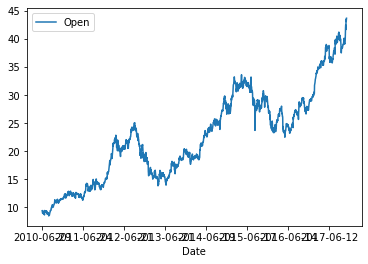

In [4]:
df_data_1.plot(x="Date", y=["Open"])

**Now, we check for any null values when doing data cleansing. Remove the first day of TSLA IPO as volume was 0.**

In [5]:
df_data_1.isnull().values.any()

False

In [6]:
df_data_1 = df_data_1.iloc[1:]
df_data_1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,2010-06-30,9.168214,9.213214,8.928928,8.983214,7.749377,739452000
2,2010-07-01,9.082143,9.100000,8.686429,8.874286,7.655411,1022896000
3,2010-07-02,8.946072,8.961785,8.685715,8.819285,7.607966,693842800
4,2010-07-06,8.964286,9.028571,8.791429,8.879642,7.660032,615235600
5,2010-07-07,8.946072,9.241786,8.919642,9.238214,7.969353,654556000


**We are really only interested in date, open, high-low(volatility), and volume for our analysis.**

In [7]:
df_data_1["High-Low"]=df_data_1["High"] - df_data_1["Low"]
df_data_1.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Open,High,Low,Close,Adj Close,Volume,High-Low
1,2010-06-30,9.168214,9.213214,8.928928,8.983214,7.749377,739452000,0.284286
2,2010-07-01,9.082143,9.100000,8.686429,8.874286,7.655411,1022896000,0.413571
3,2010-07-02,8.946072,8.961785,8.685715,8.819285,7.607966,693842800,0.276070
4,2010-07-06,8.964286,9.028571,8.791429,8.879642,7.660032,615235600,0.237142
5,2010-07-07,8.946072,9.241786,8.919642,9.238214,7.969353,654556000,0.322144


In [8]:
df_tsla = df_data_1[['Open']]
df_tsla.head()

,Open
1,9.168214
2,9.082143
3,8.946072
4,8.964286
5,8.946072


In [9]:
len(df_tsla)

1855

**Let's do some data normalization**

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

df = scaler.fit_transform(df_tsla)

In [11]:
df[:10]

array([[0.01896238],
       [0.01651465],
       [0.01264499],
       [0.01316297],
       [0.01264499],
       [0.02482276],
       [0.01914521],
       [0.02081088],
       [0.01856626],
       [0.01151757]])

**Now, we do feature engineering, using past 60 days as feature set and we predict the label on the next day. Also create a second and third set for comparison purposes (30, 45) days.**

In [13]:
features_set = []
labels = []
timesteps = 60
for i in range(timesteps, 1855):
    features_set.append(df[i-timesteps:i, 0])
    labels.append(df[i, 0])

In [14]:
features_set, labels = np.array(features_set), np.array(labels)

In [15]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [16]:
labels.shape

(1795,)

In [17]:
labels[:10]

array([0.05490665, 0.0568161 , 0.05457148, 0.04996037, 0.05175808,
       0.04886347, 0.04424221, 0.04464845, 0.05235734, 0.05311909])

In [18]:
features_set.shape

(1795, 60, 1)

In [19]:
features_set_45 = []
labels_45 = []
timesteps = 45
for i in range(timesteps, 1855):
    features_set_45.append(df[i-timesteps:i, 0])
    labels_45.append(df[i, 0])
    
features_set_45, labels_45 = np.array(features_set_45), np.array(labels_45)
features_set_45 = np.reshape(features_set_45, (features_set_45.shape[0], features_set_45.shape[1], 1))

In [20]:
features_set_70 = []
labels_70 = []
timesteps = 70
for i in range(timesteps, 1855):
    features_set_70.append(df[i-timesteps:i, 0])
    labels_70.append(df[i, 0])
    
features_set_70, labels_70 = np.array(features_set_70), np.array(labels_70)
features_set_70 = np.reshape(features_set_70, (features_set_70.shape[0], features_set_70.shape[1], 1))

**Develop and Train the LSTM**

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [44]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=400, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=400, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [45]:
model.compile(optimizer = 'adamax', loss = 'mae', metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])

In [46]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
57/57 [==============================] - 2s 40ms/step - loss: 0.1094 - mean_absolute_percentage_error: 34.4989
Epoch 2/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0567 - mean_absolute_percentage_error: 15.2782
Epoch 3/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0526 - mean_absolute_percentage_error: 14.1060
Epoch 4/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0496 - mean_absolute_percentage_error: 13.2436
Epoch 5/100
57/57 [==============================] - 2s 43ms/step - loss: 0.0524 - mean_absolute_percentage_error: 14.0213
Epoch 6/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0498 - mean_absolute_percentage_error: 13.5249
Epoch 7/100
57/57 [==============================] - 2s 42ms/step - loss: 0.0538 - mean_absolute_percentage_error: 14.2120
Epoch 8/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0478 - mean_absolute_percentage_error: 12.8404
Epoch 9/100
57/5

57/57 [==============================] - 2s 40ms/step - loss: 0.0285 - mean_absolute_percentage_error: 8.2172
Epoch 68/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0290 - mean_absolute_percentage_error: 8.3477
Epoch 69/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0282 - mean_absolute_percentage_error: 8.2961
Epoch 70/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0288 - mean_absolute_percentage_error: 8.8272
Epoch 71/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0298 - mean_absolute_percentage_error: 8.8311
Epoch 72/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0277 - mean_absolute_percentage_error: 8.1761
Epoch 73/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0263 - mean_absolute_percentage_error: 8.0540
Epoch 74/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0278 - mean_absolute_percentage_error: 7.7794
Epoch 75/100
57/57 [=========

In [47]:
model_45 = Sequential()
model_45.add(LSTM(units=100, return_sequences=True, input_shape=(features_set_45.shape[1], 1)))
model_45.add(Dropout(0.2))
model_45.add(LSTM(units=100, return_sequences=True))
model_45.add(Dropout(0.2))
model_45.add(LSTM(units=200, return_sequences=True))
model_45.add(Dropout(0.2))
model_45.add(LSTM(units=400, return_sequences=True))
model_45.add(Dropout(0.25))
model_45.add(LSTM(units=400, return_sequences=True))
model_45.add(Dropout(0.25))
model_45.add(LSTM(units=200, return_sequences=True))
model_45.add(Dropout(0.2))
model_45.add(LSTM(units=100, return_sequences=True))
model_45.add(Dropout(0.2))
model_45.add(LSTM(units=50))
model_45.add(Dropout(0.2))
model_45.add(Dense(units = 1))

In [48]:
model_45.compile(optimizer = 'adamax', loss = 'mae', metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])
model_45.fit(features_set_45, labels_45, epochs = 110, batch_size = 32)

Epoch 1/110
57/57 [==============================] - 2s 36ms/step - loss: 0.0784 - mean_absolute_percentage_error: 22.7296
Epoch 2/110
57/57 [==============================] - 2s 33ms/step - loss: 0.0580 - mean_absolute_percentage_error: 15.9108
Epoch 3/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0523 - mean_absolute_percentage_error: 14.8965
Epoch 4/110
57/57 [==============================] - 2s 33ms/step - loss: 0.0498 - mean_absolute_percentage_error: 14.0499
Epoch 5/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0502 - mean_absolute_percentage_error: 14.2421
Epoch 6/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0441 - mean_absolute_percentage_error: 12.2745
Epoch 7/110
57/57 [==============================] - 2s 34ms/step - loss: 0.0462 - mean_absolute_percentage_error: 12.5930
Epoch 8/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0407 - mean_absolute_percentage_error: 11.9241
Epoch 9/110
57/5

57/57 [==============================] - 2s 34ms/step - loss: 0.0277 - mean_absolute_percentage_error: 9.3680
Epoch 68/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0263 - mean_absolute_percentage_error: 9.0237
Epoch 69/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0274 - mean_absolute_percentage_error: 8.7886
Epoch 70/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0254 - mean_absolute_percentage_error: 8.3345
Epoch 71/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0262 - mean_absolute_percentage_error: 9.2940
Epoch 72/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0257 - mean_absolute_percentage_error: 8.6223
Epoch 73/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0258 - mean_absolute_percentage_error: 8.9159
Epoch 74/110
57/57 [==============================] - 2s 32ms/step - loss: 0.0253 - mean_absolute_percentage_error: 8.3284
Epoch 75/110
57/57 [=========

In [49]:
model_70 = Sequential()
model_70.add(LSTM(units=100, return_sequences=True, input_shape=(features_set_70.shape[1], 1)))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=100, return_sequences=True))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=200, return_sequences=True))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=400, return_sequences=True))
model_70.add(Dropout(0.25))
model_70.add(LSTM(units=400, return_sequences=True))
model_70.add(Dropout(0.25))
model_70.add(LSTM(units=200, return_sequences=True))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=100, return_sequences=True))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=100, return_sequences=True))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=100, return_sequences=True))
model_70.add(Dropout(0.2))
model_70.add(LSTM(units=50))
model_70.add(Dropout(0.2))
model_70.add(Dense(units = 1))

In [50]:
model_70.compile(optimizer = 'adam', loss = 'mae', metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])
model_70.fit(features_set_70, labels_70, epochs = 110, batch_size = 32)

Epoch 1/110
56/56 [==============================] - 3s 56ms/step - loss: 0.1107 - mean_absolute_percentage_error: 30.6677
Epoch 2/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0652 - mean_absolute_percentage_error: 19.4422
Epoch 3/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0582 - mean_absolute_percentage_error: 17.5555
Epoch 4/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0546 - mean_absolute_percentage_error: 15.4141
Epoch 5/110
56/56 [==============================] - 3s 55ms/step - loss: 0.0539 - mean_absolute_percentage_error: 15.6761
Epoch 6/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0542 - mean_absolute_percentage_error: 17.4350
Epoch 7/110
56/56 [==============================] - 3s 58ms/step - loss: 0.0502 - mean_absolute_percentage_error: 14.8380
Epoch 8/110
56/56 [==============================] - 3s 57ms/step - loss: 0.0491 - mean_absolute_percentage_error: 14.8423
Epoch 9/110
56/5

56/56 [==============================] - 3s 57ms/step - loss: 0.0243 - mean_absolute_percentage_error: 7.9280
Epoch 68/110
56/56 [==============================] - 3s 55ms/step - loss: 0.0244 - mean_absolute_percentage_error: 7.8512
Epoch 69/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0230 - mean_absolute_percentage_error: 7.7066
Epoch 70/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0231 - mean_absolute_percentage_error: 7.1672
Epoch 71/110
56/56 [==============================] - 3s 55ms/step - loss: 0.0226 - mean_absolute_percentage_error: 7.3046
Epoch 72/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0223 - mean_absolute_percentage_error: 7.4326
Epoch 73/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0231 - mean_absolute_percentage_error: 7.5151
Epoch 74/110
56/56 [==============================] - 3s 56ms/step - loss: 0.0234 - mean_absolute_percentage_error: 7.7256
Epoch 75/110
56/56 [=========

**Now, test the model again real world data from Nov 10, 2017 (where our train data ends) and forecast a couple months**

In [25]:
tsla_testing = pd.read_csv('../input/aapl-test/AAPL (2).csv')
tsla_testing.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,43.777500,44.025002,43.285000,43.970001,42.161411,117930400
1,2017-11-10,43.777500,43.845001,43.567501,43.667500,42.021866,100582000
2,2017-11-13,43.375000,43.625000,43.349998,43.492500,41.853470,67928400
3,2017-11-14,43.259998,43.369999,42.794998,42.834999,41.220745,99130000
4,2017-11-15,42.492500,42.580002,42.095001,42.270000,40.677040,116632400


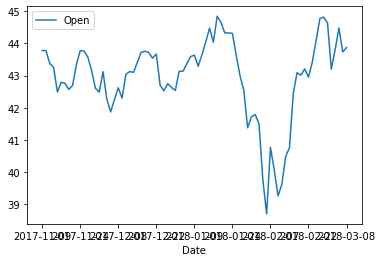

In [26]:
tsla_testing.plot(x="Date", y=["Open"])

In [27]:
tsla_testing["High-Low"]=tsla_testing["High"] - tsla_testing["Low"]
tsla_testing.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low
0,2017-11-09,43.777500,44.025002,43.285000,43.970001,42.161411,117930400,0.740002
1,2017-11-10,43.777500,43.845001,43.567501,43.667500,42.021866,100582000,0.277500
2,2017-11-13,43.375000,43.625000,43.349998,43.492500,41.853470,67928400,0.275002
3,2017-11-14,43.259998,43.369999,42.794998,42.834999,41.220745,99130000,0.575001
4,2017-11-15,42.492500,42.580002,42.095001,42.270000,40.677040,116632400,0.485001


In [51]:
df_test = tsla_testing[['Open']]

**Concatenate both the training and test datasets**

In [52]:
df_total = pd.concat((df_tsla[['Open']], df_test[['Open']]), axis=0)
df_total.tail()

,Open
76,43.200001
77,43.802502
78,44.477501
79,43.735001
80,43.869999


In [53]:
len(df_total)

1936

In [31]:
len(df_test)

81

In [32]:
df_test[['Open']]

,Open
0,43.777500
1,43.777500
2,43.375000
3,43.259998
4,42.492500
...,...
76,43.200001
77,43.802502
78,44.477501
79,43.735001


**Test different timesteps**

For timestep 60:

In [54]:
test_inputs = df_total[len(df_total) - len(df_test) - 60:].values

In [55]:
test_inputs[:10]

array([[40.485001],
       [40.130001],
       [39.465   ],
       [39.375   ],
       [39.557499],
       [39.767502],
       [40.107498],
       [39.912498],
       [40.035   ],
       [40.025002]])

In [56]:
scaler = MinMaxScaler(feature_range = (-1, 1))
test_inputs = scaler.fit_transform(test_inputs)

In [57]:
test_inputs[:10]

array([[-0.18652122],
       [-0.28318565],
       [-0.46426153],
       [-0.488768  ],
       [-0.43907459],
       [-0.381892  ],
       [-0.28931308],
       [-0.34241044],
       [-0.30905386],
       [-0.31177626]])

In [58]:
test_features = []
for i in range(60, 81):
    test_features.append(test_inputs[i-60:i, 0])

In [59]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [60]:
test_features.shape

(21, 60, 1)

In [61]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

In [62]:
predictions.shape

(21, 1)

In [63]:
predictions[:10]

array([[43.40992 ],
       [43.688347],
       [43.86218 ],
       [43.900703],
       [43.79324 ],
       [43.53025 ],
       [43.17995 ],
       [42.881313],
       [42.72587 ],
       [42.698757]], dtype=float32)

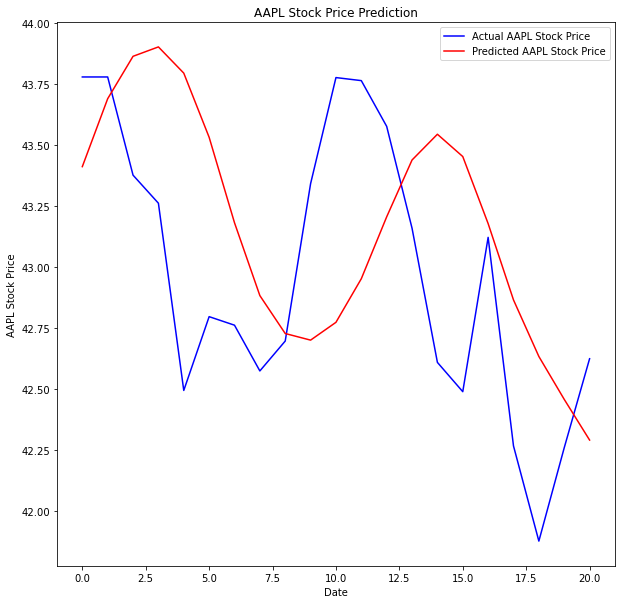

In [64]:
plt.figure(figsize=(10,10))
plt.plot((df_test[['Open']])[:21], color='blue', label='Actual AAPL Stock Price')
plt.plot(predictions, color='red', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

In [67]:
test_features_45 = []
for i in range(45, 81):
    test_features_45.append(test_inputs[i-45:i, 0])

In [68]:
test_features_45 = np.array(test_features_45)
test_features_45 = np.reshape(test_features_45, (test_features_45.shape[0], test_features_45.shape[1], 1))

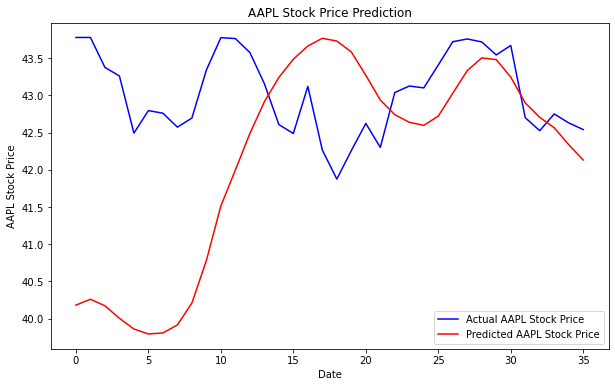

In [69]:
predictions_45 = model_45.predict(test_features_45)
# create empty table with 3 fields
testPredict_dataset_like = np.zeros(shape=(len(predictions_45), 3) )
# put the predicted values in the right field
testPredict_dataset_like[:,0] = predictions_45[:,0]
# inverse transform and then select the right field
testPredict = scaler.inverse_transform(testPredict_dataset_like)[:,0]
predictions_45 = testPredict
plt.figure(figsize=(10,6))
plt.plot((df_test[['Open']])[:36], color='blue', label='Actual AAPL Stock Price')
plt.plot(predictions_45, color='red', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

In [70]:
test_features_70 = []
for i in range(70, 81):
    test_features_70.append(test_inputs[i-70:i, 0])

In [ ]:
test_features_70 = np.array(test_features_70)
test_features_70 = np.reshape(test_features_70, (test_features_70.shape[0], test_features_70.shape[1], 1))

In [ ]:
predictions_70 = model_70.predict(test_features_70)
# create empty table with 3 fields
testPredict_dataset_like = np.zeros(shape=(len(predictions_70), 3) )
# put the predicted values in the right field
testPredict_dataset_like[:,0] = predictions_70[:,0]
# inverse transform and then select the right field
testPredict = scaler.inverse_transform(testPredict_dataset_like)[:,0]
predictions_70 = testPredict
plt.figure(figsize=(10,6))
plt.plot((df_test[['Open']])[:11], color='blue', label='Actual AAPL Stock Price')
plt.plot(predictions_70, color='red', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()